In [3]:
from bluemath_tk.predictor.xwt import XWT

daily_xwt = XWT(steps={}).load_model("outputs/dwt_model_aveiro.pkl")
dwts_to_fit = daily_xwt.steps.get("pca").pcs.kma_bmus.to_dataset(name="bmus")
dwts_to_fit["cenEOFs"] = (
    ("n_clusters", "n_features"),
    daily_xwt.steps.get("kma").kma.cluster_centers_,
)
dwts_to_fit

2025-03-31 20:03:02,039 - XWT - WARNING - Setting self.num_workers to 1. Change it using self.set_num_processors_to_use method.


<xarray.Dataset> Size: 225kB
Dimensions:  (time: 16032, n_clusters: 36, n_features: 228)
Coordinates:
  * time     (time) datetime64[s] 128kB 1980-01-01 1980-01-02 ... 2023-11-22
Dimensions without coordinates: n_clusters, n_features
Data variables:
    bmus     (time) int32 64kB 33 33 17 17 18 18 17 36 36 ... 9 9 4 9 9 9 22 22
    cenEOFs  (n_clusters, n_features) float32 33kB 0.4055 0.6576 ... 0.4737

In [4]:
import xarray as xr

waves = (
    xr.open_dataset("data/era5_aveiro.nc")
    .sel(time=dwts_to_fit.time, method="nearest")
    .rename({"swh": "bulk_Hs", "pp1d": "bulk_Tp", "mwd": "bulk_Dir"})
)
waves["bmus"] = (("time"), dwts_to_fit["bmus"].values)
waves["AWL"] = waves["bulk_Hs"] ** 2 * waves["bulk_Tp"]
waves

<xarray.Dataset> Size: 705kB
Dimensions:    (time: 16032)
Coordinates:
    longitude  float32 4B ...
    latitude   float32 4B ...
  * time       (time) datetime64[ns] 128kB 1980-01-01 1980-01-02 ... 2023-11-22
Data variables:
    bulk_Hs    (time) float64 128kB 1.669 1.963 2.18 1.79 ... 2.378 3.309 3.052
    bulk_Tp    (time) float64 128kB ...
    bulk_Dir   (time) float64 128kB ...
    bmus       (time) int32 64kB 33 33 17 17 18 18 17 36 ... 9 9 4 9 9 9 22 22
    AWL        (time) float64 128kB 28.49 51.45 64.23 ... 72.98 81.13 78.73
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-24 23:51:43 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [5]:
from bluemath_tk.teslakit.climate_emulator import Climate_Emulator

ce = Climate_Emulator(
    "/workspaces/BlueMath/climate_services/MUSCLE.Aveiro/outputs/emulator"
)

config = {
    "waves_families": ["bulk"],
    "distribution": [],
    "do_chromosomes": False,
}
ce.FitExtremes(KMA=dwts_to_fit, WVS=waves, config=config)

Waves Families: ['bulk']
Extra Variables: []
GEV distribution: ['bulk_Hs', 'bulk_Tp']
Empirical distribution: ['bulk_Dir']
Weibull distribution: []
Do chromosomes combinations: False
Max. Storms PROXY: AWL


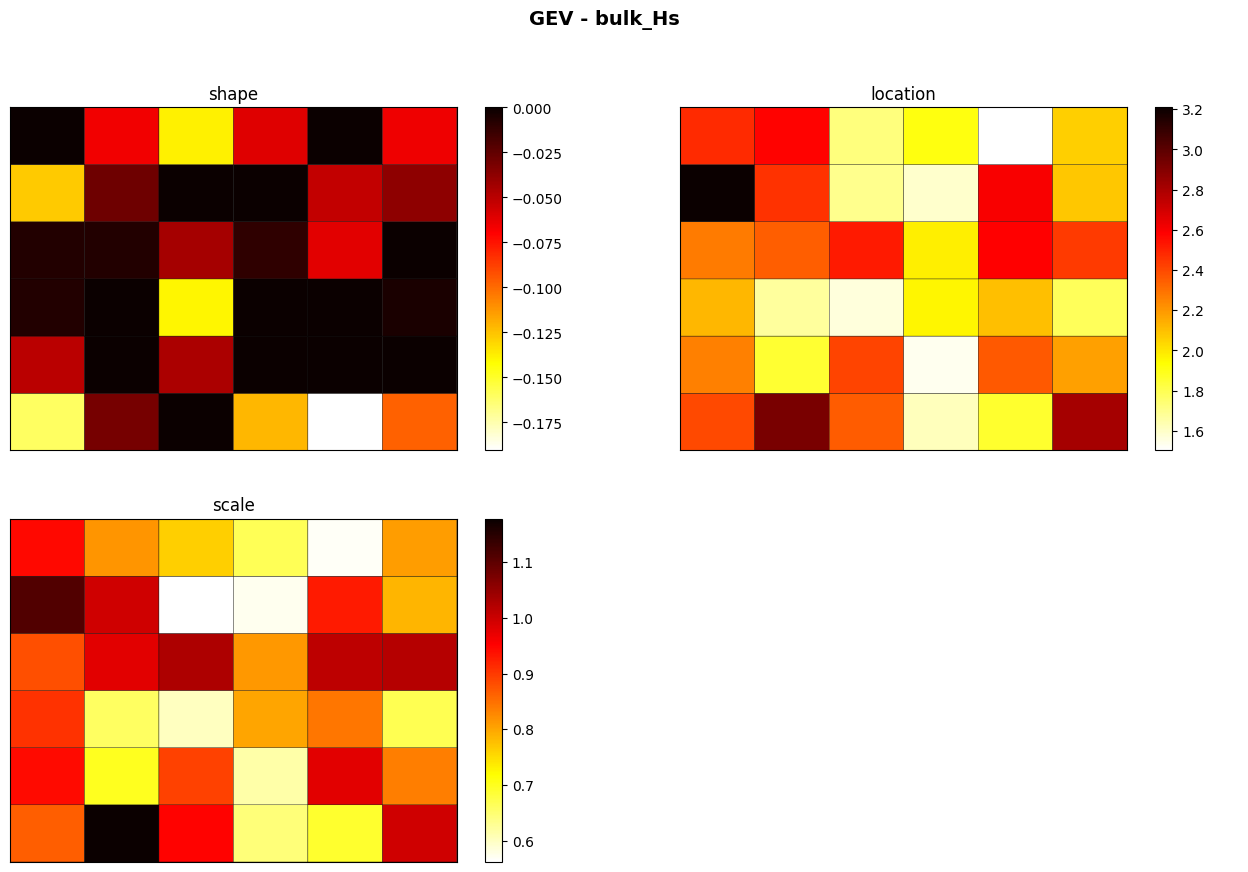

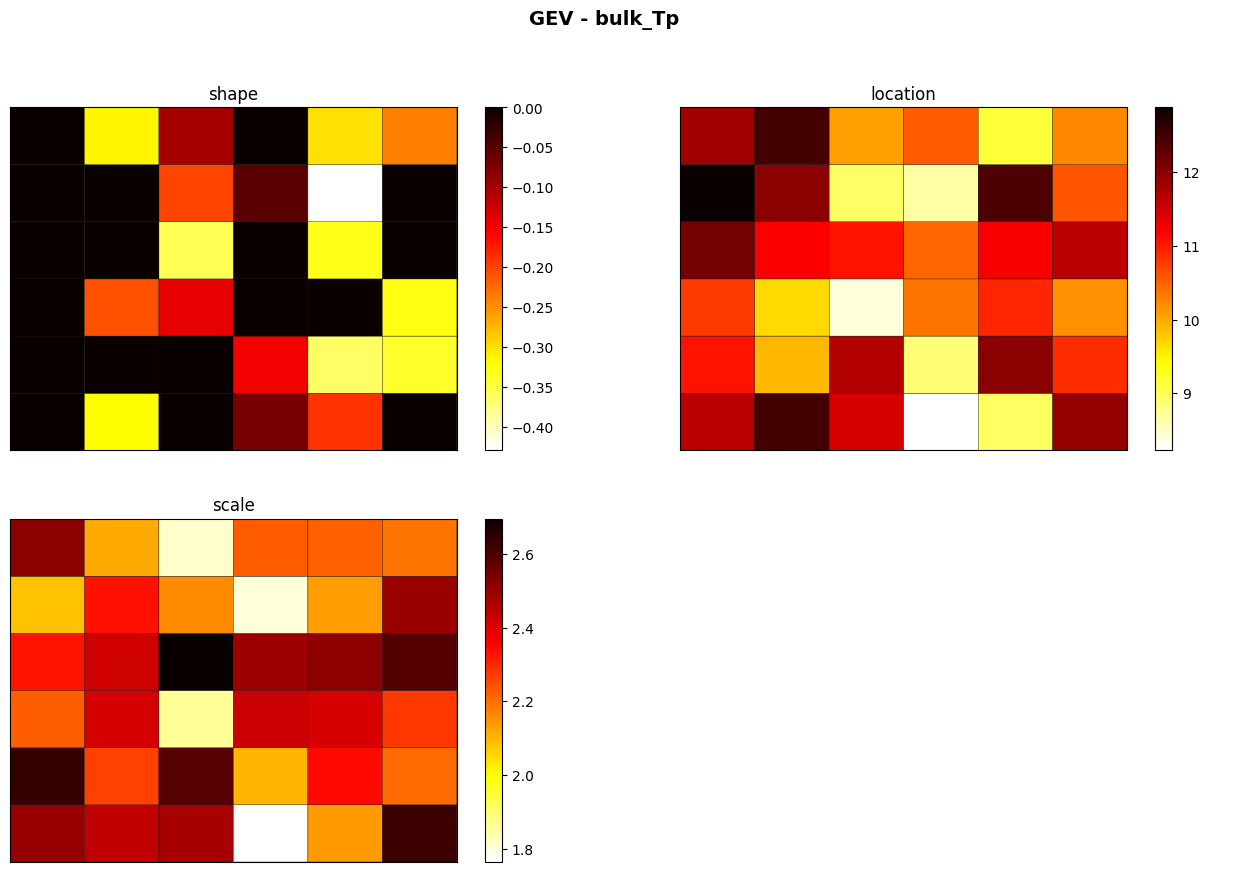

[<Figure size 1585.64x980 with 7 Axes>, <Figure size 1585.64x980 with 7 Axes>]

In [ ]:
# Fit report figures

ce.Report_Fit(vns_GEV=["Hs", "Tp"], plot_chrom=False, plot_sigma=False);

In [7]:
# Load simulated DWTs

simulated_dwts = xr.open_dataset("outputs/dwt_alr/xds_output.nc")
simulated_dwts

<xarray.Dataset> Size: 2MB
Dimensions:      (time: 36891, n_sim: 5)
Coordinates:
  * time         (time) datetime64[ns] 295kB 1999-01-01 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 738kB ...
    ofbmus_sims  (time, n_sim) float32 738kB ...

In [8]:
simulated_waves = ce.Simulate_Waves(simulated_dwts.isel(n_sim=0), 1)
simulated_waves

C.E: Sim. Waves: 100%|██████████| 16292/16292 [01:01<00:00, 263.15it/s]


<xarray.Dataset> Size: 587kB
Dimensions:   (n_sim: 1, time: 16292)
Coordinates:
  * time      (time) datetime64[ns] 130kB 1999-01-01 1999-01-02 ... 2100-01-01
Dimensions without coordinates: n_sim
Data variables:
    DWT       (n_sim, time) float32 65kB 33.0 17.0 12.0 1.0 ... 28.0 2.0 17.0
    bulk_Hs   (n_sim, time) float64 130kB 5.776 4.092 5.544 ... 4.663 3.576
    bulk_Tp   (n_sim, time) float64 130kB 14.36 19.12 14.76 ... 15.12 14.54
    bulk_Dir  (n_sim, time) float64 130kB 335.6 331.3 323.1 ... 318.0 343.7

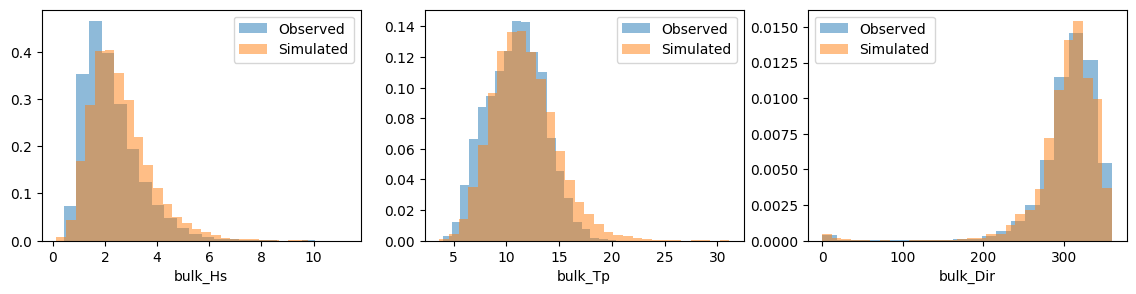

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(14, 3))
waves["bulk_Hs"].plot.hist(ax=ax[0], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Hs"].plot.hist(
    ax=ax[0], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[0].legend()
waves["bulk_Tp"].plot.hist(ax=ax[1], label="Observed", alpha=0.5, density=True, bins=20)
simulated_waves["bulk_Tp"].plot.hist(
    ax=ax[1], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[1].legend()
waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Observed", alpha=0.5, density=True, bins=20
)
simulated_waves["bulk_Dir"].plot.hist(
    ax=ax[2], label="Simulated", alpha=0.5, density=True, bins=30
)
ax[2].legend()